# Models: Generalized Matrix Factorization (GMF)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH             = '../..'
LIB_PATH              = f'{BASE_PATH}/lib'

In [3]:
import sys
sys.path.append(LIB_PATH)

import pandas as pd
from bunch import Bunch

import torch
import pytorch_common
import pytorch_common.util as pu

import model as ml
import util as ut

import model.training as mt

2023-08-22 20:16:52.572775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
pytorch_common.__version__

'0.3.2'

In [6]:
torch.__version__

'2.0.1+cu118'

In [7]:
pu.set_device_name('gpu')
pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

## Classes

## Definicion del modelo

In [9]:
train_df = pd.read_json("/var/tmp/rec-sys-client/compute_knn_item_based_rating_matrix_train_interactions.json")
test_df  = pd.read_json("/var/tmp/rec-sys-client/compute_knn_item_based_rating_matrix_future_interactions.json")

train_ds = mt.DatasetFactory().create_from(train_df)
test_ds  = mt.DatasetFactory().create_from(test_df)

In [10]:
params = Bunch({    
    'model': Bunch({
        'n_users'       : len(train_ds.features_uniques[0]),
        'n_items'       : len(train_ds.features_uniques[1]),
        'device'        : pu.get_device(),
        'embedding_size': 50,
        'weights_path'  : f'{BASE_PATH}/weights'
    }),
    'train': Bunch({
        'lr'         : 0.001,
        'lr_factor'  : 0.05,
        'lr_patience': 3,
        'epochs'     : 12,
        'n_workers'  : 24,
        'batch_size' : 64
    }),
    'metrics': Bunch({
        'experiment' : 'gmf',
        'path'       : f'{BASE_PATH}/metrics/gmf',
        'n_samples'  : 1000,
        'batch_size' : 5000
    })
})

In [11]:
model = ml.GMF(
    n_users        = params.model.n_users,
    n_items        = params.model.n_items,
    embedding_size = params.model.embedding_size
)

trainer = mt.ModuleTrainer(model)

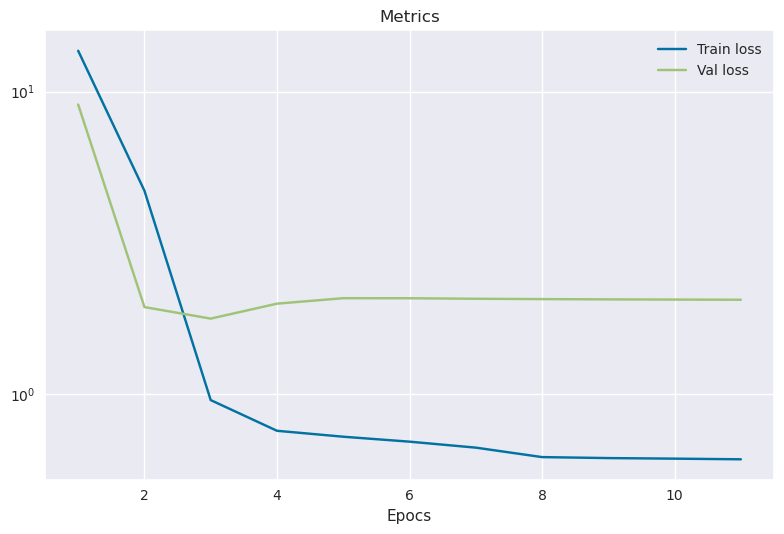

2023-08-22 20:18:30,317 - INFO - {'time': '0:00:07.69', 'epoch': 12, 'train_loss': 0.6040122793380157, 'val_loss': 2.048682451248169, 'lr': 2.5e-06}


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
trainer(train_ds, test_ds, params)

In [ ]:
resolver = pu.WeightsFileResolver(params.model.weights_path)

weights_file_path = resolver(experiment=params.metrics.experiment, metric='val_loss')

weights_file_path

In [ ]:
model.load(weights_file_path)